In this assignment, we produce a price forecasts of Price Indexes for 10 major metropolitan markets. Along with the price series, several additional open-source data sets have been provided.

Let's import the relevant packages for this task, namely Pandas and NumPy for data manipulation, and matplotlib.pyplot for data vizualization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Exploration
Let's import the data. All data series are regrouped by area. 10 areas are provided. 'CPI' stands for Cadre Price Index. 'FMPHI' tracks the average 30-year fixed mortgage rate, non-seasonally adjusted. 'ZMI' refers to median income by Zillow's Research group. 'ZHI' refers to the Home Value Index by the provider. 'ZRI' refers to the Rent Value Index. 'Pop' shows the population evolution for each one of those areas. 'Rates' refer to the 30 year US mortgage rate.

Since we are dealing with time series forecasting, we need to assign timestamps to our historical observations (rows).

CPI data columns are names of the area. For more standardization, columns names are renamed using to the './market_to_name.csv' mapping.

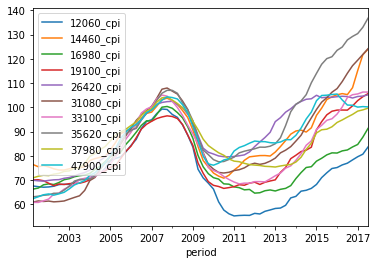

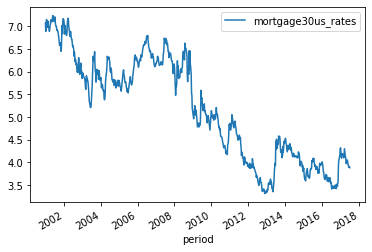

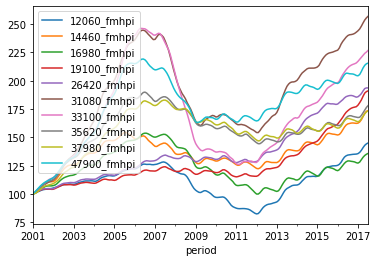

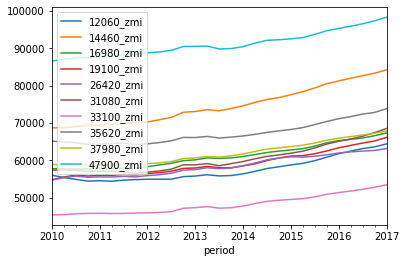

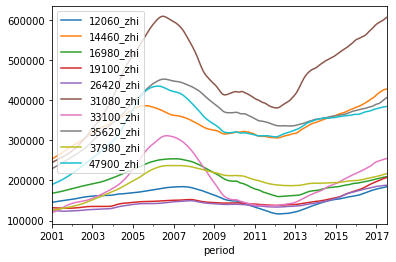

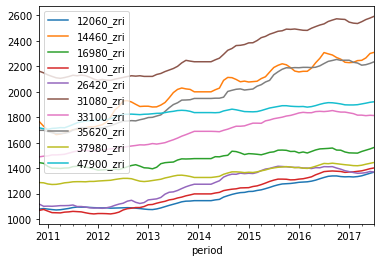

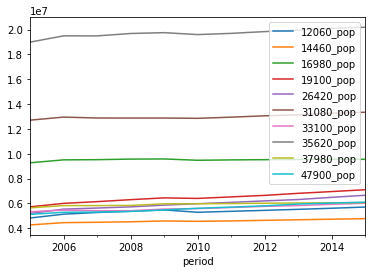

In [3]:
from datetime import datetime

cpi = pd.read_csv('./cpi.csv')
cpi['period'] = pd.to_datetime(cpi['period'])
cpi.set_index('period', inplace=True)

names = pd.read_csv('./market_to_name.csv').set_index('name')
d = names.to_dict().get('cbsa')
cpi.rename(columns = d, inplace = True)
#convert CPI data column names to string
cpi.columns = cpi.columns.astype(str) + '_cpi'
cpi.plot()

rates = pd.read_csv('./30_Year_FRM.csv')
rates['period']=pd.to_datetime(rates['period'])
rates.set_index('period', inplace=True)
rates.columns += '_rates'
rates.plot()

fmhpi = pd.read_csv('./fmhpi.csv')
fmhpi['period']=pd.to_datetime(fmhpi['period'])
fmhpi.set_index('period', inplace=True)
fmhpi.columns += '_fmhpi'
fmhpi.plot()

zmi = pd.read_csv('./zillow_mi_market.csv')
zmi['period'] = pd.to_datetime(zmi['period'])
zmi.set_index('period', inplace=True)
zmi.columns += '_zmi'
zmi.plot()

zhi = pd.read_csv('./zillow_hi_market.csv')
zhi['period']=pd.to_datetime(zhi['period'])
zhi.set_index('period', inplace=True)
zhi.columns += '_zhi'
zhi.plot()

zri = pd.read_csv('./zillow_ri_market.csv')
zri['period']=pd.to_datetime(zri['period'])
zri.set_index('period', inplace=True)
zri.columns += '_zri'
zri.plot()

pop = pd.read_csv('./market_pop.csv')
pop['period']=pd.to_datetime(pop['period'])
pop.set_index('period', inplace=True)
pop.columns += '_pop'
pop.plot()

Since the goal is to forecast CPI, it makes sense to see how other data evolve with CPI.

/Users/khalilmejouate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


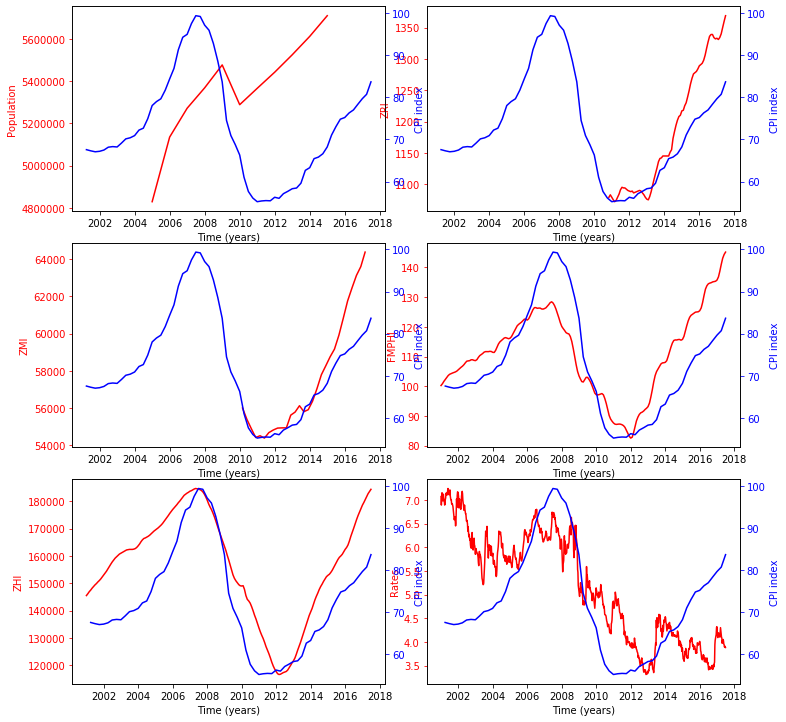

In [4]:
# Define a function called plot_timeseries
def plot_timeseries(axes, x, y, color, xlabel, ylabel):

  # Plot the inputs x,y in the provided color
  axes.plot(x, y, color=color)

  # Set the x-axis label
  axes.set_xlabel(xlabel)

  # Set the y-axis label
  axes.set_ylabel(ylabel, color=color)

  # Set the colors tick params for y-axis
  axes.tick_params('y', colors=color)

fig, ax = plt.subplots(3, 2, constrained_layout=True, figsize = (10,10))
fig.tight_layout()

plot_timeseries(ax[0,0], pop.index, pop['12060_pop'], "red", 'Time (years)', 'Population')
plot_timeseries(ax[1,0], zmi.index, zmi['12060_zmi'], "red", 'Time (years)', 'ZMI')
plot_timeseries(ax[2,0], zhi.index, zhi['12060_zhi'], "red", 'Time (years)', 'ZHI')
plot_timeseries(ax[0,1], zri.index, zri['12060_zri'], "red", 'Time (years)', 'ZRI')
plot_timeseries(ax[1,1], fmhpi.index, fmhpi['12060_fmhpi'], "red", 'Time (years)', 'FMPHI')
plot_timeseries(ax[2,1], rates.index, rates['mortgage30us_rates'], "red", 'Time (years)', 'Rates')



for i in range(3):
    for j in range(2):
# Create a twin Axes object that shares the x-axis
        ax2 = ax[i,j].twinx()
        plot_timeseries(ax2, cpi.index, cpi['12060_cpi'], "blue", 'Time (years)', 'CPI index')

plt.show()


# Data Wrangling 
One first remark is that data does not share the same timestamps as CPI. The latter is submitted quarterly and also would be forecast quartely.
Secondly, there is some correlation between the series and the CPI, if not causality. We'll dig more into that later.
It is now necessary to match CPI timestamps with all other data time indexes. CPI timestamps are quarterly and observations in other data series do not land on the same quarter dates. Linear Interpolation in one option.

Also, some data series do not go far enough in the past, or far enough to the most recent date. A simple approach is to extrapolate flat outside their current intervals

Finally, all data is grouped by area codes (markets) and stored in the dictionary 'final_dfs'.

In [5]:
#list of indexes
dfs = [pop, fmhpi, zhi, zmi, zri, cpi, rates]
dfs_names = ['pop', 'fmhpi', 'zhi', 'zmi', 'zri', 'cpi', 'rates']

#create empty dataframe with matching Time Stamps
df_index = pd.DataFrame().reindex(cpi.index)


#reindexing function with (time) interpolation and (flat) extrapolation
def reindex_cpi(df):
    df = df.reindex(pd.date_range(start=cpi.index.min(),
                                                  end=cpi.index.max(),
                                                  freq='D')).interpolate(method = 'time').ffill().bfill()
    df = df.reindex(pd.date_range(start=cpi.index.min(),
                                                  end=cpi.index.max(),
                                                  freq='QS-APR'))
    return df

#dictionary of final dataframes (data grouped by area)
final_dfs = dict()

#adding variables for reindexed dataframes
for df, name in zip(dfs, dfs_names):
    globals()[name + '_rdx'] = reindex_cpi(df)

#storing area code (key) and corresponding data series (value) in the dictionary
for key, value in d.items():
    df = df_index
    for name in dfs_names:
        df__ = globals()[name + '_rdx']
        df = pd.concat([df, df__[[col for col in df__.columns if str(value) in col]]], axis = 1)
    df = pd.concat([df, rates_rdx], axis = 1)
    final_dfs[str(value)] = df

In [6]:
#storing area codes in a list
area_name = [str(value) for key, value in d.items()]
print('There are ', len(area_name), 'areas.')
area_name

There are  10 areas.


['12060',
 '14460',
 '16980',
 '19100',
 '26420',
 '31080',
 '33100',
 '35620',
 '37980',
 '47900']

## Split data
We will perform forecasting on an area example: Atlanta-Sandy Springs-Marietta, GA Metro Area (area code: 12060, area number: 0)

Since data has different scales, it is wise to standardize it.

As in most machine learning algorithms, it’s a good idea to split data into training and testing set. We will build a model to forecast 6 quarterly data points.

In [7]:
area_nb = 0

X = final_dfs[area_name[area_nb]]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
data = scaler.transform(X)

n_obs = 6

#creating the train set
train = data[:-n_obs]
train_df = pd.DataFrame(train)
train_df.columns = X.columns

#creating the test set
test = data[-n_obs:]
test_df = pd.DataFrame(test)
test_df.columns = X.columns

## Test for causality
As mentioned earlier would want to see if there’s a correlation between data and CPI with various lags. For that you can run Granger’s causality test. Although the name suggests, it’s really not a test of “causality”, you cannot say if one is causing the other, all you can say is if there is an association between the variables.

Feature selection would be different if the objective is primarily to forecast other variables.

In [8]:
import statsmodels.api as sm
# import for Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests

for col in X.columns:
    print('++++++++++++++++++++++++',col, '++++++++++++++++++++++++')
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    granger_test = sm.tsa.stattools.grangercausalitytests(X[[col, area_name[area_nb]+'_cpi']], maxlag=5, verbose=True)
    print(granger_test.keys)

++++++++++++++++++++++++ 12060_pop ++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6812  , p=0.1996  , df_denom=62, df_num=1
ssr based chi2 test:   chi2=1.7625  , p=0.1843  , df=1
likelihood ratio test: chi2=1.7391  , p=0.1873  , df=1
parameter F test:         F=1.6812  , p=0.1996  , df_denom=62, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2193  , p=0.1177  , df_denom=59, df_num=2
ssr based chi2 test:   chi2=4.8147  , p=0.0901  , df=2
likelihood ratio test: chi2=4.6422  , p=0.0982  , df=2
parameter F test:         F=2.2193  , p=0.1177  , df_denom=59, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8606  , p=0.1468  , df_denom=56, df_num=3
ssr based chi2 test:   chi2=6.2797  , p=0.0988  , df=3
likelihood ratio test: chi2=5.9861  , p=0.1123  , df=3
parameter F test:         F=1.8606  , p=0.1468  , df

30-year mortgage rates are not believed to be contributing to CPI evolution (p-value > 0.05 for all lags). Same goes ZRI and ZMI.

We can drop the corresponding columns. Then, we will instantiate another Standardization scaler and fit it.

In [9]:
X_d = X.drop(columns = [ area_name[area_nb]+'_zmi', area_name[area_nb]+'_zri', 'mortgage30us_rates'])

scaler_d = StandardScaler()
scaler_d.fit(X_d)
data = scaler_d.transform(X_d)

#creating the train and validation set
train = data[:-n_obs]
valid = data[-n_obs:]

#transform back to a DataFrame
train_df = pd.DataFrame(train)
train_df.columns = X_d.columns

## Test for stationarity
For time series modeling, data needs to be stationary — meaning if there is a trend in the data we need to get rid of it. To check whether data is stationary, we call Augmented Dickey-Fuller (ADF) Test.

In [10]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller

def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
        adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
        
#apply adf test on the series
adf_test(train_df[area_name[area_nb] + '_cpi'])
adf_test(train_df[area_name[area_nb] + '_fmhpi'])
adf_test(train_df[area_name[area_nb] + '_pop'])
adf_test(train_df[area_name[area_nb] + '_zhi'])
# adf_test(train_df[area_name[area_nb] + '_zri'])  ##dropped
# adf_test(train_df[area_name[area_nb] + '_zmi'])  ##dropped
# adf_test(train_df["mortgage30us_rates"])         ##dropped

Test Statistic          -2.815499
p-value                  0.056094
# Lags                   3.000000
# Observations          56.000000
Critical Value (1%)     -3.552928
Critical Value (5%)     -2.914731
Critical Value (10%)    -2.595137
dtype: float64
 Series is Non-Stationary
Test Statistic          -3.495567
p-value                  0.008102
# Lags                  11.000000
# Observations          48.000000
Critical Value (1%)     -3.574589
Critical Value (5%)     -2.923954
Critical Value (10%)    -2.600039
dtype: float64
 Series is Stationary
Test Statistic          -1.107490
p-value                  0.712076
# Lags                   5.000000
# Observations          54.000000
Critical Value (1%)     -3.557709
Critical Value (5%)     -2.916770
Critical Value (10%)    -2.596222
dtype: float64
 Series is Non-Stationary
Test Statistic          -3.605445
p-value                  0.005658
# Lags                   1.000000
# Observations          58.000000
Critical Value (1%)     -3.5484

We see that
CPI   series in non-stationary,
FMHPI series is stationary,
ZHI   series is stationary.

If the data is not stationary we can make it so in several ways, but the simplest one is taking a first difference. After taking first difference we need to go back to the previous step to test again if the data is now stationary. If not, a second difference may be necessary.

In [11]:
# 1st difference
train_df1 = train_df.diff().dropna()
# stationarity test again with differenced data
adf_test(train_df1[area_name[area_nb] + '_cpi'])
adf_test(train_df1[area_name[area_nb] + '_fmhpi'])
adf_test(train_df1[area_name[area_nb] + '_pop'])
adf_test(train_df1[area_name[area_nb] + '_zhi'])
# adf_test(train_df[area_name[area_nb] + '_zri'])
# adf_test(train_df1[area_name[area_nb] + '_zmi'])
# adf_test(train_df1["mortgage30us_rates"])

Test Statistic          -2.582858
p-value                  0.096592
# Lags                   0.000000
# Observations          58.000000
Critical Value (1%)     -3.548494
Critical Value (5%)     -2.912837
Critical Value (10%)    -2.594129
dtype: float64
 Series is Non-Stationary
Test Statistic          -1.871285
p-value                  0.345688
# Lags                   4.000000
# Observations          54.000000
Critical Value (1%)     -3.557709
Critical Value (5%)     -2.916770
Critical Value (10%)    -2.596222
dtype: float64
 Series is Non-Stationary
Test Statistic          -2.260282
p-value                  0.185098
# Lags                   4.000000
# Observations          54.000000
Critical Value (1%)     -3.557709
Critical Value (5%)     -2.916770
Critical Value (10%)    -2.596222
dtype: float64
 Series is Non-Stationary
Test Statistic          -2.150191
p-value                  0.224817
# Lags                   3.000000
# Observations          55.000000
Critical Value (1%)     -3.

All data series are still not stationary. Another difference is needed.

In [12]:
# 2nd difference for stationarity
train_df1 = train_df1.diff().dropna()

# stationarity test with new differenced data
adf_test(train_df1[area_name[area_nb] + '_cpi'])
adf_test(train_df1[area_name[area_nb] + '_fmhpi'])
adf_test(train_df1[area_name[area_nb] + '_pop'])
adf_test(train_df1[area_name[area_nb] + '_zhi'])
# adf_test(train_df[area_name[area_nb] + '_zri'])
# adf_test(train_df1[area_name[area_nb] + '_zmi'])
# adf_test(train_df1["mortgage30us_rates"])

Test Statistic         -9.042148e+00
p-value                 5.099384e-15
# Lags                  0.000000e+00
# Observations          5.700000e+01
Critical Value (1%)    -3.550670e+00
Critical Value (5%)    -2.913766e+00
Critical Value (10%)   -2.594624e+00
dtype: float64
 Series is Stationary
Test Statistic          -3.291923
p-value                  0.015243
# Lags                   3.000000
# Observations          54.000000
Critical Value (1%)     -3.557709
Critical Value (5%)     -2.916770
Critical Value (10%)    -2.596222
dtype: float64
 Series is Stationary
Test Statistic         -5.700533e+00
p-value                 7.694551e-07
# Lags                  3.000000e+00
# Observations          5.400000e+01
Critical Value (1%)    -3.557709e+00
Critical Value (5%)    -2.916770e+00
Critical Value (10%)   -2.596222e+00
dtype: float64
 Series is Stationary
Test Statistic         -5.752950e+00
p-value                 5.908435e-07
# Lags                  0.000000e+00
# Observations        

## Fit the model
We are interested in modeling a 𝑇×𝐾 multivariate time series 𝑌, where 𝑇
T denotes the number of observations and 𝐾 K the number of variables. One way of estimating relationships between the time series and their lagged values is the vector autoregression process:

$$ 𝑌_𝑡=𝜈+𝐴_1𝑌_{𝑡−1}+…+𝐴_𝑝𝑌_{𝑡−𝑝}+𝑢_𝑡 $$ 
$$ 𝑢_𝑡∼ N(0,Σ_𝑢) $$

where 𝐴_𝑖 is a $𝐾×𝐾$ coefficient matrix.
We can now instantiate the model with VAR() and then fit the model to secondly differenced data. After running the model you can check the summary results below.

In [13]:
from statsmodels.tsa.api import VAR

# model fitting
model = VAR(train_df1)
results = model.fit(maxlags=5, ic='aic')

/Users/khalilmejouate/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Forecasting data
Now that the model is set up, it’s time to do actual forecast. Here I  asked the model to forecast the 6 steps ahead, previously mentioned. The model returns an array of 6 forecast values for both the variables. We also plot the forecast values along with associated standard errors.

[[-0.01928896  0.23223994  0.03109954  0.07220893]
 [-0.00445768 -0.01454973 -0.055012   -0.14382223]
 [ 0.01779465 -0.19655073  0.02588341  0.19491121]
 [-0.02364834 -0.05368986 -0.00602984 -0.11802453]
 [ 0.00801019  0.26299855 -0.01179949 -0.03634248]]


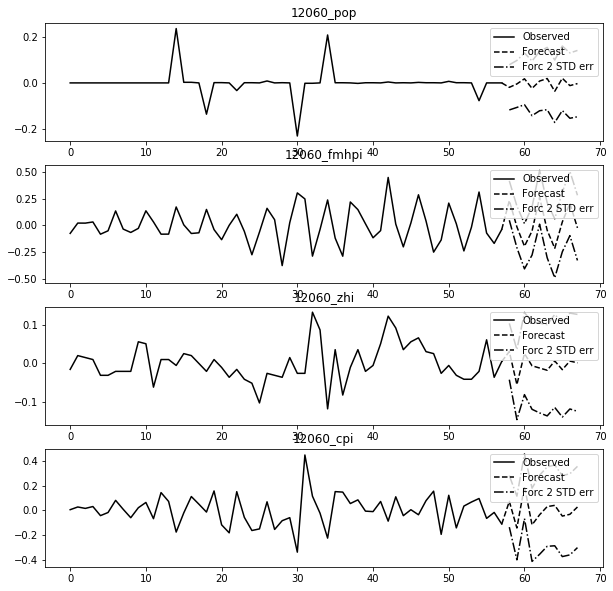

In [14]:
# forecasting
lag_order = results.k_ar
print(results.forecast(train_df1.values[-lag_order:], lag_order))
results.plot_forecast(10)
plt.show()

## Inverting data
One final step remains. We didn’t fit the model to original data, because we had to transform (first and second differences) it to make data stationary, earlier. So the forecast results need to be inverted to the original form.

In [15]:
# forecasting
pred = results.forecast(results.y, steps=n_obs)
pred_df = pd.DataFrame(pred, index=X.index[-n_obs:], columns=train_df.columns + '_1d')

def invert_transformation(df_train, df_forecast, n_diff):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
#         # Roll back 4th Diff
#         if 4 <= n_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-3]-df_train[col].iloc[-4]) + df_fc[str(col)+'_1d'].cumsum()
#         # Roll back 3rd Diff
#         if 3 <= n_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-2]-df_train[col].iloc[-3]) + df_fc[str(col)+'_1d'].cumsum()
#         # Roll back 2nd Diff
        if 2 <= n_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# show inverted results in a dataframe
df_forecast = invert_transformation(train_df, pred_df, 2)
df_forecast.loc[:, [col for col in df_forecast if str('_forecast') in col]]

/Users/khalilmejouate/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,12060_pop_forecast,12060_fmhpi_forecast,12060_zhi_forecast,12060_cpi_forecast
2016-04-01,1.256873,1.224643,0.443651,0.293295
2016-07-01,1.233127,1.476557,0.542990,0.253245
2016-10-01,1.227175,1.531920,0.668213,0.408106
2017-01-01,1.197574,1.533594,0.787406,0.444943
2017-04-01,1.175984,1.798266,0.894799,0.445437
2017-07-01,1.173368,2.016620,0.984512,0.475536


In [16]:
df = df_forecast[[col for col in df_forecast.columns if str('_forecast') in col]]
forecast = pd.DataFrame(scaler_d.inverse_transform(df), index=X_d.index[-n_obs:], columns=X_d.columns)
forecast.head()

,12060_pop,12060_fmhpi,12060_zhi,12060_cpi
2016-04-01,5.703539e+06,129.285516,165405.580401,76.481159
2016-07-01,5.695916e+06,132.935990,167339.948978,75.984375
2016-10-01,5.694005e+06,133.738257,169778.327856,77.905279
2017-01-01,5.684503e+06,133.762509,172099.291609,78.362201
2017-04-01,5.677572e+06,137.597857,174190.491741,78.368329


## Evaluating model
Let's look at how the model performed. CPI forecast has a mean absolute error of 1.699 with a percentage error of 2.17 percent.

In [17]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(forecast[area_name[area_nb] + '_cpi'], X[area_name[area_nb] + '_cpi'][-n_obs:]))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(forecast[area_name[area_nb] + '_cpi'], X[area_name[area_nb] + '_cpi'][-n_obs:]))


1.6986291851221484
2.170908049277581


Here is a plot of our forecasts for the population, ZHI index, FMHPI index and CPI index.

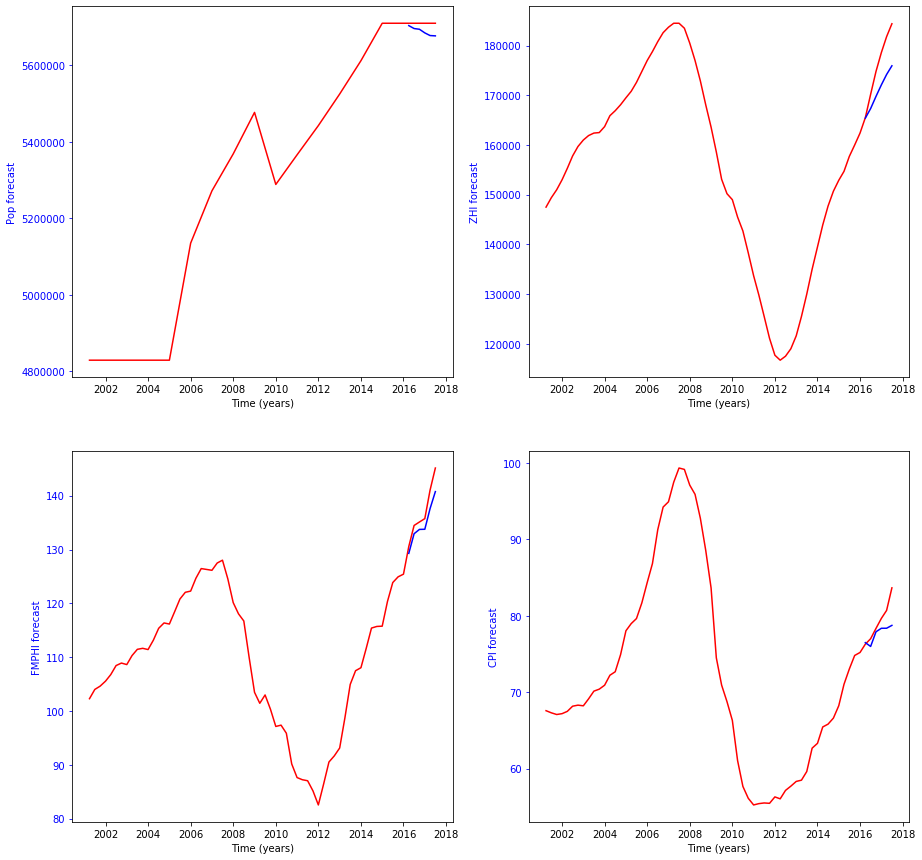

In [18]:
fig, ax = plt.subplots(2,2, figsize = (15,15))

plot_timeseries(ax[0,0], pop_rdx.index, pop_rdx[area_name[area_nb] + '_pop'], "red", 'Time (years)', 'Population')
plot_timeseries(ax[0,0], forecast.index, forecast[area_name[area_nb] + '_pop'], "blue", 'Time (years)', 'Pop forecast')
# plot_timeseries(ax[0,1], zmi_rdx.index, zmi_rdx[area_name[area_nb] + '_zmi'], "red", 'Time (years)', 'ZMI')
# plot_timeseries(ax[0,1], forecast.index, forecast[area_name[area_nb] + '_zmi'], "blue", 'Time (years)', 'ZMI forecast')
plot_timeseries(ax[0,1], zhi_rdx.index, zhi_rdx[area_name[area_nb] + '_zhi'], "red", 'Time (years)', 'ZHI')
plot_timeseries(ax[0,1], forecast.index, forecast[area_name[area_nb] + '_zhi'], "blue", 'Time (years)', 'ZHI forecast')
# plot_timeseries(ax[1,0], zri_rdx.index, zri_rdx[area_name[area_nb] + '_zri'], "red", 'Time (years)', 'ZRI')
# plot_timeseries(ax[1,0], forecast.index, forecast[area_name[area_nb] + '_zri'], "blue", 'Time (years)', 'ZRI forecast')
# plot_timeseries(ax[1,1], rates_rdx.index, rates_rdx['mortgage30us_rates'], "red", 'Time (years)', 'Rates')
# plot_timeseries(ax[1,1], forecast.index, forecast['mortgage30us_rates'], "blue", 'Time (years)', 'Rates forecast')
plot_timeseries(ax[1,0], fmhpi_rdx.index, fmhpi_rdx[area_name[area_nb] + '_fmhpi'], "red", 'Time (years)', 'FMPHI')
plot_timeseries(ax[1,0], forecast.index, forecast[area_name[area_nb] + '_fmhpi'], "blue", 'Time (years)', 'FMPHI forecast')
plot_timeseries(ax[1,1], cpi.index, cpi[area_name[area_nb] + '_cpi'], "red", 'Time (years)', 'CPI')
plot_timeseries(ax[1,1], forecast.index, forecast[area_name[area_nb] + '_cpi'], "blue", 'Time (years)', 'CPI forecast')

# Submission
Finally, we fit the model on the entire (reindexed, standardized, differenced) series for the area 12060 to submit the 8 quarterly forecasts. Same procedure would apply to all other areas.
Find attached hereafter the submission csv of all CPI forecasts (10 series)

In [48]:
area_nb = 0 ## 1,2,..., 9

X = final_dfs[area_name[area_nb]]

X = X.drop(columns = [area_name[area_nb]+'_zmi', area_name[area_nb]+'_zri', 'mortgage30us_rates'])

from sklearn.preprocessing import StandardScaler
scaler_0 = StandardScaler()
scaler_0.fit(X)
data_0 = scaler_0.transform(X)

data_0 = pd.DataFrame(data_0)
data_0.columns = X.columns


# difference for stationarity
data_0 = data_0.diff().dropna()
#..twice
data_0 = data_0.diff().dropna()

# stationarity test with new differenced data
adf_test(data_0[area_name[area_nb] + '_cpi'])
adf_test(data_0[area_name[area_nb] + '_fmhpi'])
adf_test(data_0[area_name[area_nb] + '_pop'])
adf_test(data_0[area_name[area_nb] + '_zhi'])

Test Statistic          -2.588590
p-value                  0.095378
# Lags                   0.000000
# Observations          64.000000
Critical Value (1%)     -3.536928
Critical Value (5%)     -2.907887
Critical Value (10%)    -2.591493
dtype: float64
 Series is Non-Stationary
Test Statistic          -1.846789
p-value                  0.357492
# Lags                   4.000000
# Observations          60.000000
Critical Value (1%)     -3.544369
Critical Value (5%)     -2.911073
Critical Value (10%)    -2.593190
dtype: float64
 Series is Non-Stationary
Test Statistic          -2.285688
p-value                  0.176625
# Lags                   4.000000
# Observations          60.000000
Critical Value (1%)     -3.544369
Critical Value (5%)     -2.911073
Critical Value (10%)    -2.593190
dtype: float64
 Series is Non-Stationary
Test Statistic          -2.157571
p-value                  0.222004
# Lags                   3.000000
# Observations          61.000000
Critical Value (1%)     -3.

/Users/khalilmejouate/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4
[[ 0.03548985 -0.25920073  0.01079172  0.04210299]
 [ 0.00465722  0.04023692 -0.00121968 -0.12020159]
 [ 0.01749955  0.29955267 -0.00213546 -0.02574528]
 [-0.01725841 -0.06546048  0.01053033  0.07205351]
 [-0.019777   -0.24066305  0.01586522  0.06656412]
 [ 0.00251182  0.07511607  0.00227917 -0.06017853]
 [-0.00050425  0.26002698  0.01257977 -0.02525524]
 [ 0.00854593 -0.08521678 -0.00047828  0.05572639]]


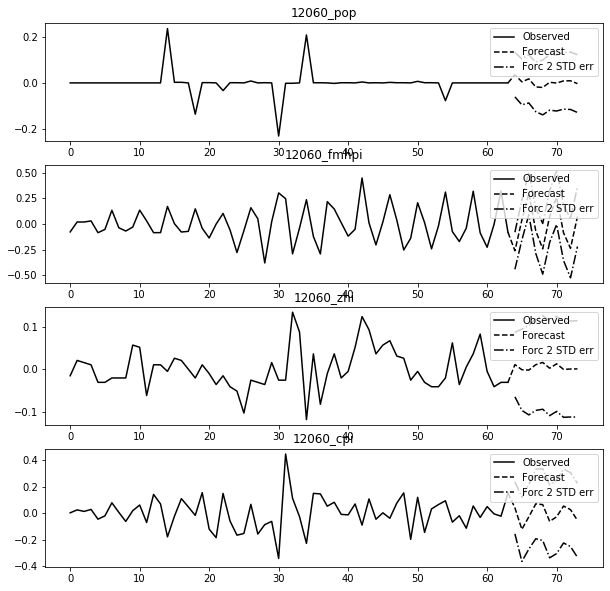

In [50]:
from statsmodels.tsa.api import VAR
# model fitting
model_0 = VAR(data_0)
results = model_0.fit(maxlags=5, ic='aic')

# forecasting
lag_order = results.k_ar
print(lag_order)
print(results.forecast(data_0.values[-lag_order:], 8))
results.plot_forecast(10)
plt.show()

In [51]:
# forecasting
pred = results.forecast(results.y, steps=8)
pred_df = pd.DataFrame(pred, columns=data_0.columns + '_1d')

# show inverted results in a dataframe
pred_df = invert_transformation(data_0, pred_df, 2)
pred_df.loc[:, [col for col in pred_df if str('_forecast') in col]]

/Users/khalilmejouate/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,12060_pop_forecast,12060_fmhpi_forecast,12060_zhi_forecast,12060_cpi_forecast
0,0.035490,-0.741037,-0.020021,0.370353
1,0.075637,-1.361596,-0.010449,0.466779
2,0.133284,-1.682603,-0.003013,0.537460
3,0.173672,-2.069070,0.014954,0.680194
4,0.194283,-2.696200,0.048786,0.889492
5,0.217406,-3.248214,0.084898,1.038612
6,0.240025,-3.540201,0.133589,1.162476
7,0.271190,-3.917405,0.181802,1.342067


In [52]:
pred_df = pred_df[[col for col in pred_df.columns if str('_forecast') in col]]

#setting indexes from 4Q 2017 to 3Q 2019 inclusive
pred_dates = pd.date_range(start='2017-10-01', periods=8, freq='3MS')

#inverse scaler transformation and keep the CPI forecasts only
pred_cpi = pd.DataFrame(scaler_0.inverse_transform(pred_df), 
                                   index=pred_dates, 
                                   columns=data_0.columns)

#rename the only (CPI Forecast) column with the area code only
pred_cpi = pred_cpi[[area_name[area_nb] + '_cpi']]
pred_cpi.columns = [col[:-4] for col in pred_cpi.columns]

pred_cpi[area_name[area_nb]] = X[area_name[area_nb]+'_cpi'].iloc[-1]- pred_cpi[area_name[area_nb]][0] + pred_cpi[area_name[area_nb]]
pred_cpi.head()

,12060
2017-10-01,83.657211
2018-01-01,84.853281
2018-04-01,85.730007
2018-07-01,87.500487
2018-10-01,90.096631


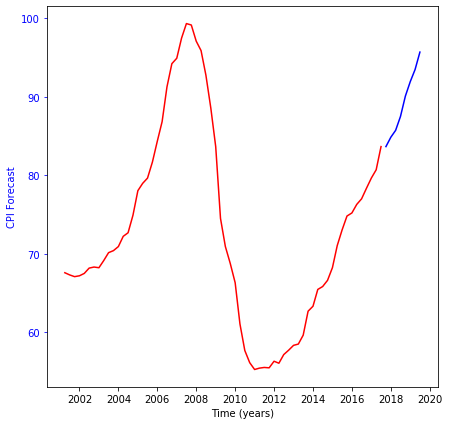

In [53]:
fig, ax = plt.subplots(figsize = (7,7))

plot_timeseries(ax, cpi.index, cpi[area_name[area_nb] + '_cpi'], "red", 'Time (years)', 'CPI')
plot_timeseries(ax, pred_dates, pred_cpi, "blue", 'Time (years)', 'CPI Forecast')


Submission format has to be the same as the CPI csv. Let's rename the column to area name back from its code.

In [39]:
names = pd.read_csv('./market_to_name.csv').set_index('name')
d = names.to_dict().get('cbsa')
d = {str(y):x for x,y in d.items()}
pred_cpi.rename(columns = d, inplace = True)

In [40]:
pred_cpi.to_csv('./submission0.csv')